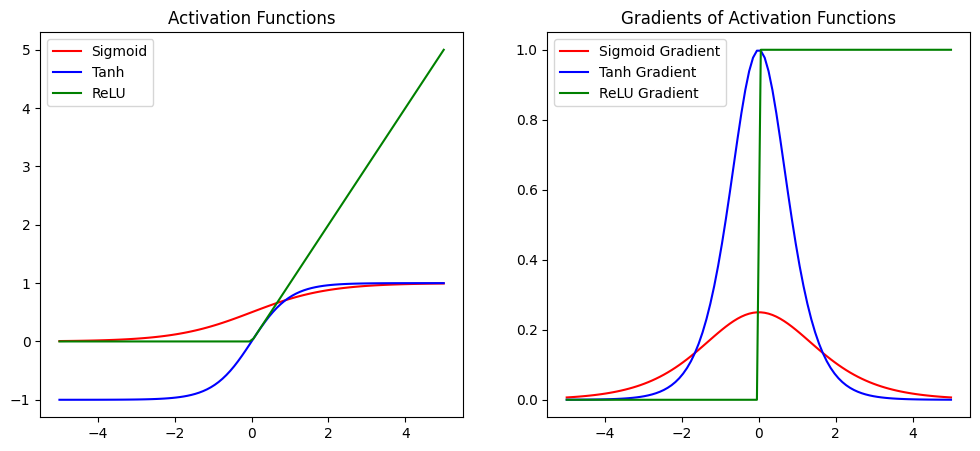

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Define activation functions
x = np.linspace(-5, 5, 100)

sigmoid = 1 / (1 + np.exp(-x))
sigmoid_grad = sigmoid * (1 - sigmoid)

tanh = np.tanh(x)
tanh_grad = 1 - np.square(tanh)

relu = np.maximum(0, x)
relu_grad = np.where(x > 0, 1, 0)

# Plot activations
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x, sigmoid, label="Sigmoid", color="red")
plt.plot(x, tanh, label="Tanh", color="blue")
plt.plot(x, relu, label="ReLU", color="green")
plt.legend()
plt.title("Activation Functions")

# Plot gradients
plt.subplot(1, 2, 2)
plt.plot(x, sigmoid_grad, label="Sigmoid Gradient", color="red")
plt.plot(x, tanh_grad, label="Tanh Gradient", color="blue")
plt.plot(x, relu_grad, label="ReLU Gradient", color="green")
plt.legend()
plt.title("Gradients of Activation Functions")

plt.show()

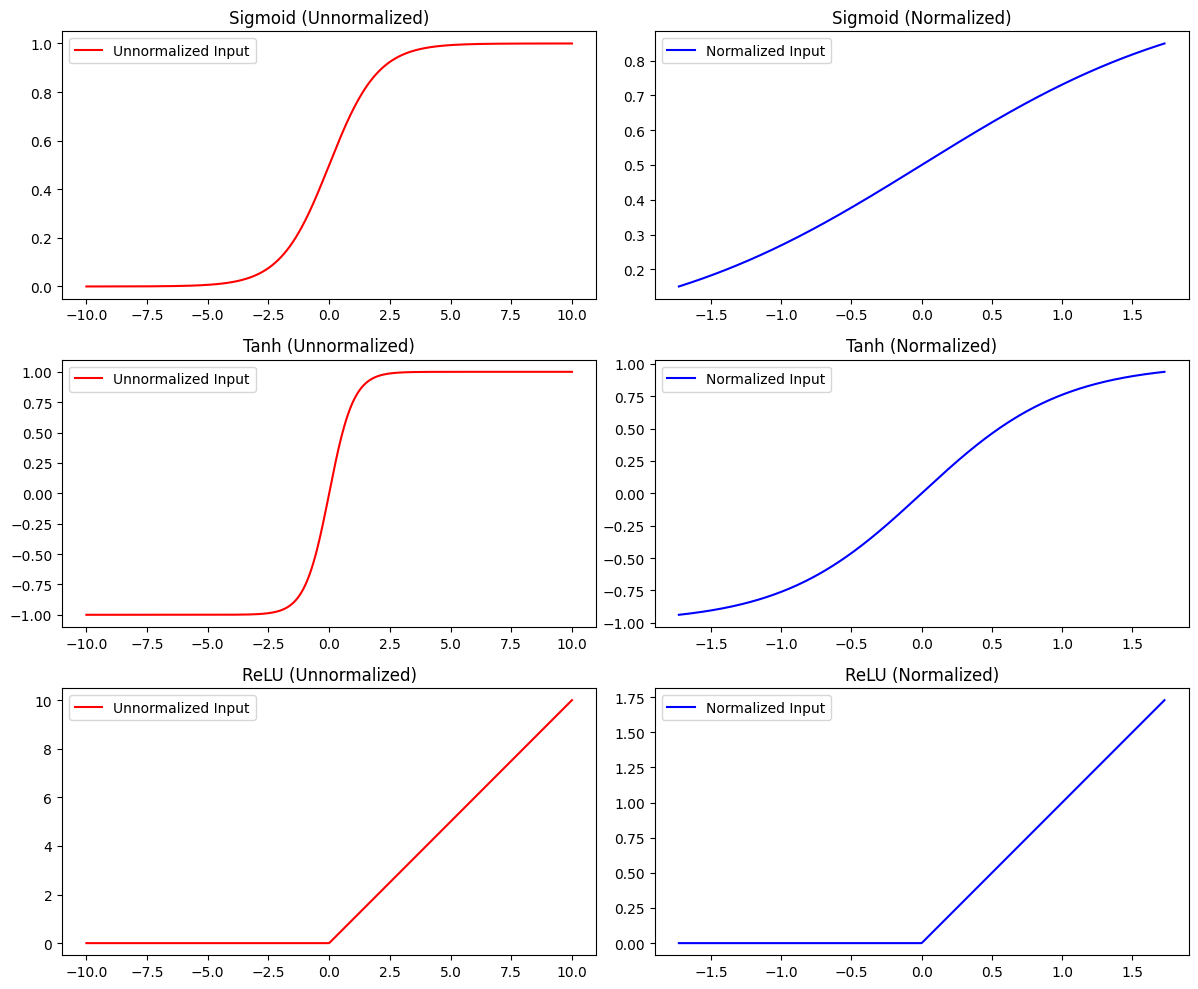

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# Generate raw, unnormalized data (random numbers from a wide range)
x = np.linspace(-10, 10, 500)

# Standardize the data (mean = 0, std = 1)
x_normalized = (x - np.mean(x)) / np.std(x)

# Define activation functions
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def tanh(x):
    return np.tanh(x)

def relu(x):
    return np.maximum(0, x)

# Compute activations for raw and normalized inputs
y_sigmoid_raw = sigmoid(x)
y_sigmoid_norm = sigmoid(x_normalized)

y_tanh_raw = tanh(x)
y_tanh_norm = tanh(x_normalized)

y_relu_raw = relu(x)
y_relu_norm = relu(x_normalized)

# Plot results
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

activations = [
    ("Sigmoid", y_sigmoid_raw, y_sigmoid_norm),
    ("Tanh", y_tanh_raw, y_tanh_norm),
    ("ReLU", y_relu_raw, y_relu_norm),
]

for i, (title, y_raw, y_norm) in enumerate(activations):
    axes[i, 0].plot(x, y_raw, label="Unnormalized Input", color="red")
    axes[i, 1].plot(x_normalized, y_norm, label="Normalized Input", color="blue")
    
    axes[i, 0].set_title(f"{title} (Unnormalized)")
    axes[i, 1].set_title(f"{title} (Normalized)")
    
    axes[i, 0].legend()
    axes[i, 1].legend()

plt.tight_layout()
plt.show()


In [4]:
import numpy as np

# Simulating a layer with 5 neurons
neurons = np.array([1.0, 2.0, 3.0, 4.0, 5.0])

# Dropout during training (50% probability of keeping a neuron)
dropout_mask = np.random.binomial(1, 0.5, size=neurons.shape)
training_output = neurons * dropout_mask  # Only some neurons remain active

# At test time: Use all neurons but scale down by 0.5
test_output = neurons * 0.5

print("Neurons before dropout:", neurons)
print("Dropout mask (0 means neuron is dropped):", dropout_mask)
print("Training output (some neurons dropped):", training_output)
print("Test output (all neurons but scaled by 0.5):", test_output)


Neurons before dropout: [1. 2. 3. 4. 5.]
Dropout mask (0 means neuron is dropped): [0 1 0 1 0]
Training output (some neurons dropped): [0. 2. 0. 4. 0.]
Test output (all neurons but scaled by 0.5): [0.5 1.  1.5 2.  2.5]


In [1]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [2]:
import torch
print(torch.__version__)  # Check PyTorch version
print(torch.version.cuda)  # Check if CUDA is installed with PyTorch
print(torch.backends.cudnn.enabled)  # Check if cuDNN is enabled

2.6.0+cu118
11.8
True


### AlexNet model from scratch

From [paper](https://papers.nips.cc/paper_files/paper/2012/file/c399862d3b9d6b76c8436e924a68c45b-Paper.pdf)- 


Feature exrtaction layers:
* input size = 256 x 256 x 3
* first layer -> input filter size (224 x 224 x 3), 96 kernels of size (11 x 11 x 3), stride = 4
* second layer -> response-norm(k = 2, n = 5, alpha = 10^4, and beta = 0.75) & pooled (kernel,z=3, stride,s=2),input size (11 x 11 x 3), 256 kernels of size (5 x 5 x 48), stride = 1
* third layer -> input size (5 x 5 x 48), 384 kernels of size (3 x 3 x 256), stride = 1
* fourth layer -> input size (3 x 3 x 256), 384 kernels of size (3 x 3 x 192), stride = 1
* fifth layer -> input size (3 x 3 x 192), 256 kernels of size (3 x 3 x 192), stride = 1
* sixth layer -> maxpool layer (z=3,s=2)

Classifier layers:
* Dropout - 0.5
* Linear layer = input size: 256*6*6=9216, out size: 

Initialization parameters:
* each layer weights -> zero mean Gaussian distrib with SD = 0.01
* bias for 2nd, 4th and 5th conv layer and FC hidden layers -> 1
* biases in remaining layers -> 0

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


class myAlexNet(nn.Module):

    def __init__(self, num_classes=1000):
        super(myAlexNet, self).__init__()
        #Feature extraction
        self.net = nn.Sequential(
            #1st layer
            nn.Conv2d(in_channels=3, out_channels=96, kernel_size=11, stride=4),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #2nd layer
            nn.Conv2d(in_channels=96, out_channels=256, kernel_size=5, padding=2),
            nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),
            #3rd layer
            nn.Conv2d(in_channels=256, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            #4th layer
            nn.Conv2d(in_channels=384, out_channels=384, kernel_size=3, padding=1),
            nn.ReLU(),
            #5th layer
            nn.Conv2d(in_channels=384, out_channels=256, kernel_size=3, padding=1),
            nn.ReLU(),
            #6th layer
            nn.MaxPool2d(kernel_size=3, stride=2), #Turn on ceil mode True or else it shit will go brrrr!
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        #Classifier
        self.linear = nn.Sequential(
            nn.Dropout(p=0.5),
            nn.Linear(in_features=(256*6*6), out_features=4096),
            nn.ReLU(),

            nn.Dropout(p=0.5),
            nn.Linear(in_features=4096, out_features=4096),
            nn.ReLU(),

            nn.Linear(in_features=4096, out_features=num_classes)   
        )
    
    def init_bias(self,):
        for layer in self.net:
            if isinstance(layer, nn.Conv2d):
                nn.init.normal_(layer.weight, mean=0, std=0.01)
                nn.init.constant_(layer.bias, 0)

        nn.init.constant_(self.net[4].bias, 1) # setting bias of 2th conv layer to 1
        nn.init.constant_(self.net[10].bias, 1) # setting bias of 4th conv layer to 1
        nn.init.constant_(self.net[12].bias, 1) # setting bias of 5th conv layer to 1


    def forward(self, x):
        x = self.net(x)
        x = self.avgpool(x)
        # print("Shape before flattening:", x.shape)
        x = x.view(-1, 256*6*6)  #Automatically flattens without hardcoding 9216
        # print("Shape after  flattening:", x.shape)
        x = self.linear(x)
        return x
                

In [4]:
model = myAlexNet(10)
model.to(device)

myAlexNet(
  (net): Sequential(
    (0): Conv2d(3, 96, kernel_size=(11, 11), stride=(4, 4))
    (1): ReLU()
    (2): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (5): ReLU()
    (6): LocalResponseNorm(5, alpha=0.0001, beta=0.75, k=2)
    (7): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (8): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): Conv2d(384, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU()
    (12): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU()
    (14): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_feature

In [4]:
x = torch.randn(1, 3, 224, 224).to(device)
output = model(x)
print(output.shape)

torch.Size([1, 10])


In [5]:
from torchsummary import summary
summary(model, (3,224,224))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 96, 54, 54]          34,944
              ReLU-2           [-1, 96, 54, 54]               0
 LocalResponseNorm-3           [-1, 96, 54, 54]               0
         MaxPool2d-4           [-1, 96, 26, 26]               0
            Conv2d-5          [-1, 256, 26, 26]         614,656
              ReLU-6          [-1, 256, 26, 26]               0
 LocalResponseNorm-7          [-1, 256, 26, 26]               0
         MaxPool2d-8          [-1, 256, 12, 12]               0
            Conv2d-9          [-1, 384, 12, 12]         885,120
             ReLU-10          [-1, 384, 12, 12]               0
           Conv2d-11          [-1, 384, 12, 12]       1,327,488
             ReLU-12          [-1, 384, 12, 12]               0
           Conv2d-13          [-1, 256, 12, 12]         884,992
             ReLU-14          [-1, 256,

In [5]:
NUM_EPOCHS = 90  # original paper
BATCH_SIZE = 64
MOMENTUM = 0.9
LR_DECAY = 0.0005
LR_INIT = 0.01
IMAGE_DIM = 224  # pixels
NUM_CLASSES = 10 

LOG_DIR = 'tblogs'
CHECKPOINT_DIR = 'models'

In [6]:
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

transform = transforms.Compose([
    transforms.Resize((IMAGE_DIM,IMAGE_DIM)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
print('Dataloader created')

trainset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = DataLoader(
    trainset, 
    shuffle=True,
    pin_memory=True,
    num_workers=8,
    drop_last=True,
    batch_size=BATCH_SIZE)

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = DataLoader(
    testset, 
    shuffle=False,
    batch_size=BATCH_SIZE)

Dataloader created


In [8]:
import torch.optim as optim
optimizer = optim.SGD(
        params=model.parameters(),
        lr=LR_INIT,
        momentum=MOMENTUM,
        weight_decay=LR_DECAY)
print('Optimizer created')

Optimizer created


In [9]:
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.1)
print('LR Scheduler created')

LR Scheduler created


In [10]:
from tensorboardX import SummaryWriter
tbwriter = SummaryWriter(log_dir=LOG_DIR)
print('TensorboardX summary writer created')

TensorboardX summary writer created


In [11]:
import torch.nn.functional as F
import os

print('Starting training...')
total_steps = 1
train_losses = []
train_accuracies = []
total = 0
correct = 0

for epoch in range(NUM_EPOCHS):
    model.train()
    running_loss = 0.0

    for imgs, classes in trainloader:
        imgs, classes = imgs.to(device), classes.to(device)
        optimizer.zero_grad()

        # Forward pass
        output = model(imgs)
        loss = F.cross_entropy(output, classes)

        # Backpropagation
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        # Calculate accuracy
        if total_steps % 10 == 0:
            with torch.no_grad():
                _, preds = torch.max(output, 1)
                accuracy = torch.sum(preds == classes).item() / classes.size(0) * 100

                print(f'Epoch: {epoch + 1} \tStep: {total_steps} \tLoss: {loss.item():.4f} \tAcc: {accuracy:.2f}%')

                tbwriter.add_scalar('loss', loss.item(), total_steps)
                tbwriter.add_scalar('accuracy', accuracy, total_steps)

        total_steps += 1  # Update step count

    # Call LR scheduler *after* the epoch
    lr_scheduler.step()

    # Save checkpoint
    checkpoint_path = os.path.join(CHECKPOINT_DIR, f'alexnet_states_e{epoch + 1}.pkl')
    state = {
        'epoch': epoch,
        'total_steps': total_steps,
        'optimizer': optimizer.state_dict(),
        'model': model.state_dict(),
    }
    torch.save(state, checkpoint_path)




Starting training...
Epoch: 1 	Step: 10 	Loss: 2.3009 	Acc: 15.62%
Epoch: 1 	Step: 20 	Loss: 2.3038 	Acc: 3.12%
Epoch: 1 	Step: 30 	Loss: 2.3056 	Acc: 10.94%
Epoch: 1 	Step: 40 	Loss: 2.3033 	Acc: 10.94%
Epoch: 1 	Step: 50 	Loss: 2.3017 	Acc: 14.06%
Epoch: 1 	Step: 60 	Loss: 2.3050 	Acc: 6.25%
Epoch: 1 	Step: 70 	Loss: 2.3069 	Acc: 1.56%
Epoch: 1 	Step: 80 	Loss: 2.3038 	Acc: 10.94%
Epoch: 1 	Step: 90 	Loss: 2.3060 	Acc: 4.69%
Epoch: 1 	Step: 100 	Loss: 2.3047 	Acc: 4.69%
Epoch: 1 	Step: 110 	Loss: 2.3027 	Acc: 9.38%
Epoch: 1 	Step: 120 	Loss: 2.3001 	Acc: 10.94%
Epoch: 1 	Step: 130 	Loss: 2.3044 	Acc: 7.81%
Epoch: 1 	Step: 140 	Loss: 2.3035 	Acc: 9.38%
Epoch: 1 	Step: 150 	Loss: 2.3053 	Acc: 12.50%
Epoch: 1 	Step: 160 	Loss: 2.2975 	Acc: 15.62%
Epoch: 1 	Step: 170 	Loss: 2.2927 	Acc: 26.56%
Epoch: 1 	Step: 180 	Loss: 2.3030 	Acc: 14.06%
Epoch: 1 	Step: 190 	Loss: 2.3003 	Acc: 15.62%
Epoch: 1 	Step: 200 	Loss: 2.2896 	Acc: 20.31%
Epoch: 1 	Step: 210 	Loss: 2.2933 	Acc: 15.62%
Epoch: 1 

KeyboardInterrupt: 

In [13]:
model.eval()

correct = 0
total = 0
running_loss = 0.0

# Disable gradient computation
with torch.no_grad():
    for step, (images, labels) in enumerate(testloader):
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = F.cross_entropy(outputs, labels)
        running_loss += loss.item()

        # Get predictions
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

        # Log to TensorBoard
        tbwriter.add_scalar('Test/Loss', loss.item(), step)
        tbwriter.add_scalar('Test/Accuracy', correct / total, step)

# Compute final test accuracy
final_test_acc = correct / total
final_test_loss = running_loss / len(testloader)

print(f"\nFinal Test Accuracy: {final_test_acc:.4f}")
print(f"Final Test Loss: {final_test_loss:.4f}")



Final Test Accuracy: 0.8365
Final Test Loss: 0.6713


In [1]:
import matplotlib.pyplot as plt
import random

# Set the model to evaluation mode
model.eval()

# Pick a random batch index
random_idx = random.randint(0, len(testloader) - 1)

# Get a random batch from the test loader
for i, (images, labels) in enumerate(testloader):
    if i == random_idx:
        break

# Move images and labels to device
images, labels = images.to(device), labels.to(device)

# Forward pass (no gradients needed)
with torch.no_grad():
    outputs = model(images)
    _, preds = torch.max(outputs, 1)

# Define class labels for CIFAR-10
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# Plot the images with predicted and actual labels
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):  # Display 5 images
    img = images[i].cpu().numpy().transpose((1, 2, 0))  # Convert tensor to image format
    img = (img - img.min()) / (img.max() - img.min())  # Normalize for display

    axes[i].imshow(img)
    axes[i].set_title(f"Pred: {classes[preds[i]]}\nActual: {classes[labels[i]]}")
    axes[i].axis('off')

plt.show()


NameError: name 'model' is not defined

### Model testing

In [15]:
from PIL import Image
import matplotlib.pyplot as plt

img = Image.open("test_images/bird.png").convert("RGB")
input_image = transform(img).unsqueeze(0)
print(input_image.shape)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
#load model
model = myAlexNet(10).to(device)
checkpoint_path = "models/alexnet_states_e30.pkl"  
checkpoint = torch.load(checkpoint_path, map_location=device)
model.load_state_dict(checkpoint['model'])


torch.Size([1, 3, 224, 224])


<All keys matched successfully>

Predicted Class: bird


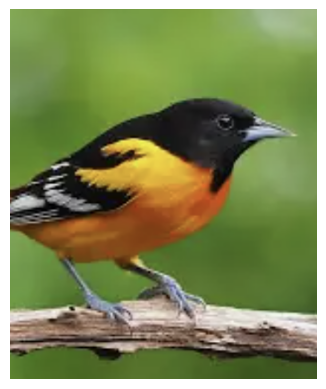

In [16]:
input_image = input_image.to(device)
model.eval()
with torch.no_grad():
    output = model(input_image)
    _,pred = torch.max(output,1)

plt.imshow(img)
plt.axis("off")
print(f"Predicted Class: {classes[pred.item()]}")


#### Testing and visualizing model over epochs

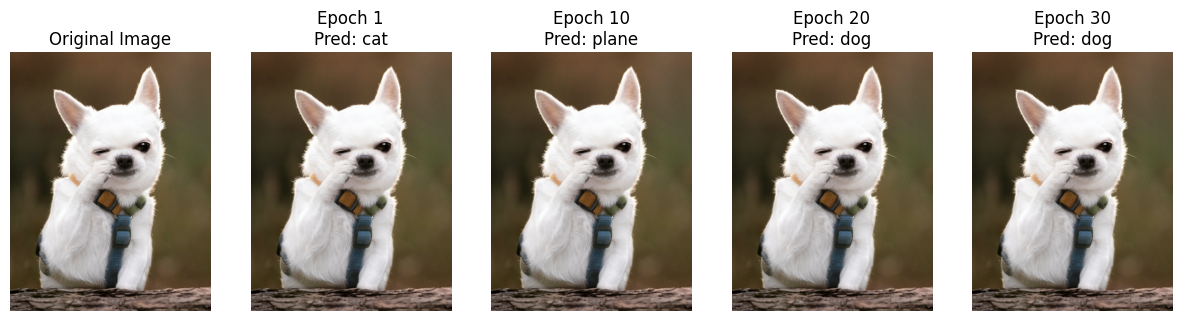

In [34]:
# Define paths to your saved checkpoints
checkpoint_paths = [
    "models/alexnet_states_e1.pkl",
    "models/alexnet_states_e10.pkl",
    "models/alexnet_states_e20.pkl",
    "models/alexnet_states_e30.pkl"
]
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# Load a test image
img_path = "test_images/dog.png"  # Change to any test image
img = Image.open(img_path).convert("RGB")

img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
img_tensor = img_tensor.to(device) 
# Initialize figure for visualization
fig, axes = plt.subplots(1, len(checkpoint_paths) + 1, figsize=(15, 5))

# Show original image
axes[0].imshow(img)
axes[0].set_title("Original Image")
axes[0].axis("off")

# Load model and compare predictions
for i, checkpoint_path in enumerate(checkpoint_paths):
    # Load model state
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model.eval()

    # Make prediction
    with torch.no_grad():
        output = model(img_tensor)
        _, predicted = torch.max(output, 1)

    # Show predictions
    axes[i + 1].imshow(img)
    axes[i + 1].set_title(f"Epoch {checkpoint_path.split('.')[-2].split('_')[-1][1:]}\nPred: {classes[predicted.item()]}")
    axes[i + 1].axis("off")

plt.show()


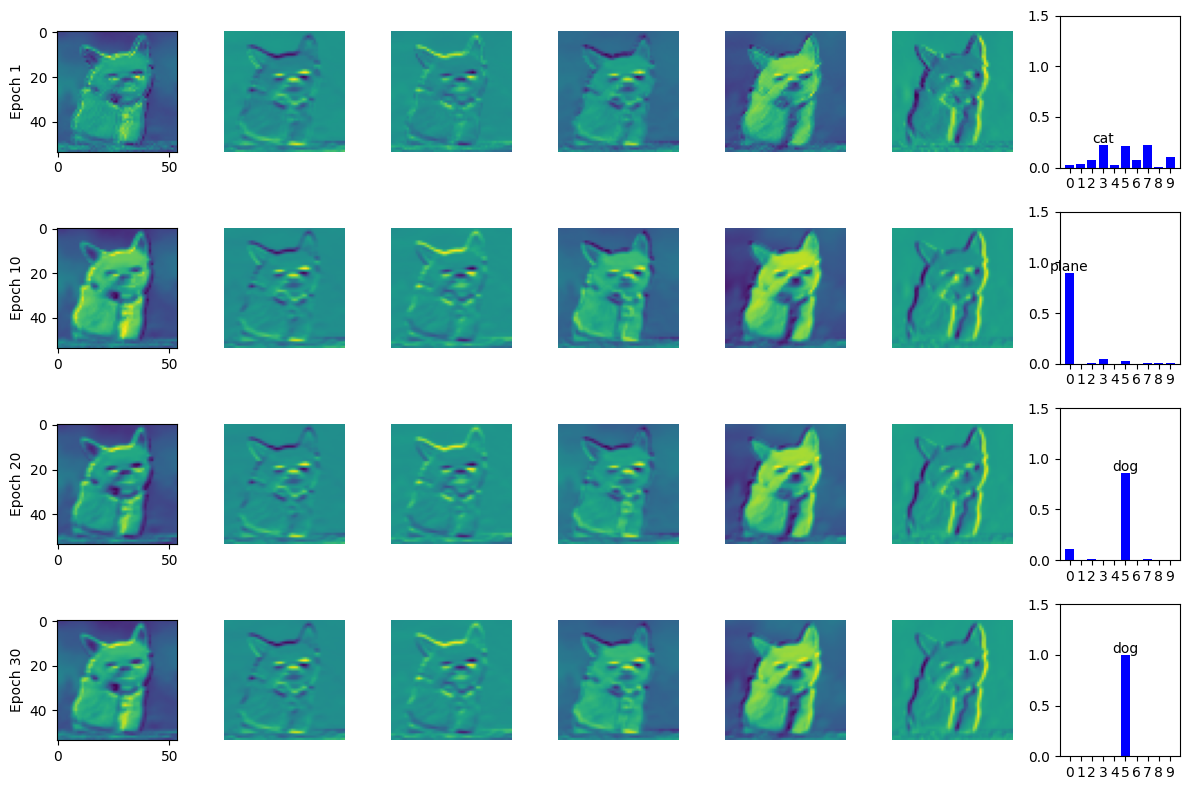

In [36]:
# Function to extract feature maps from a given layer

def get_feature_maps(model, img_tensor, layer_idx):
    activation = None
    def hook_fn(module, input, output):
        nonlocal activation
        activation = output.detach()

    # Register hook to extract activation
    hook = model.net[layer_idx].register_forward_hook(hook_fn)

    # Forward pass
    model(img_tensor)

    # Remove hook
    hook.remove()

    return activation

# Choose a convolutional layer to visualize (e.g., first Conv layer)
layer_idx = 0  # Change this to visualize other layers (0-14)
fig, axes = plt.subplots(len(checkpoint_paths), 7, figsize=(12, len(checkpoint_paths) * 2))  # Extra column for prob. dist.

for i, checkpoint_path in enumerate(checkpoint_paths):
    # Load model state
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model'])
    model.eval()

    # Extract feature maps
    feature_maps = get_feature_maps(model, img_tensor, layer_idx)

    # Select a few feature maps to visualize
    for j in range(6):
        axes[i, j].imshow(feature_maps[0, j].cpu().numpy(), cmap="viridis")
        if j != 0:  axes[i, j].axis("off")

    # Get model output probabilities
    with torch.no_grad():
        logits = model(img_tensor)  # Add batch dimension
        probs = F.softmax(logits, dim=1).squeeze().cpu().numpy()  # Convert to probability distribution

    # Plot probability distribution
    axes[i, 6].bar(range(len(probs)), probs, color="blue")  # Adjust x-ticks to match class indices
    axes[i, 6].set_ylim(0, 1.5)
    axes[i, 6].set_xticks(range(len(probs)))
    max_prob_idx = probs.argmax()
    axes[i, 6].text(max_prob_idx, probs[max_prob_idx] + 0.02, classes[max_prob_idx], ha='center', color='black')

    # Label each epoch
    axes[i, 0].set_ylabel(f"Epoch {checkpoint_path.split('.')[-2].split('_')[-1][1:]}")

plt.tight_layout()
plt.show()


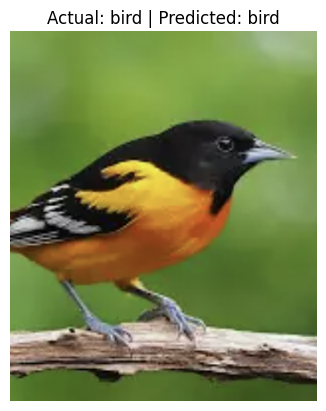

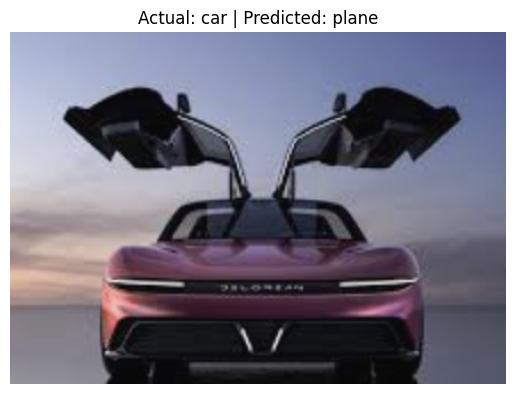

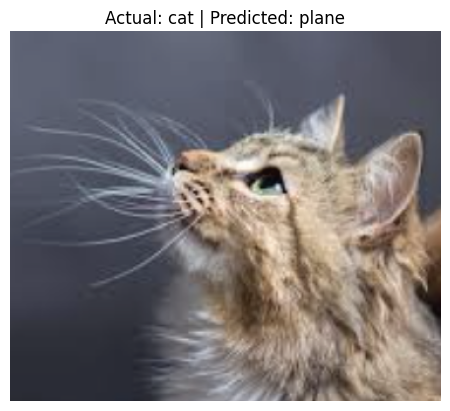

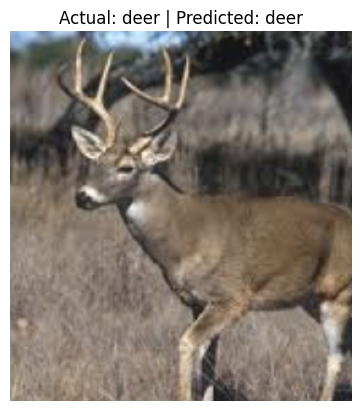

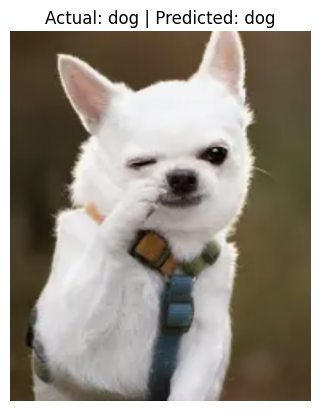

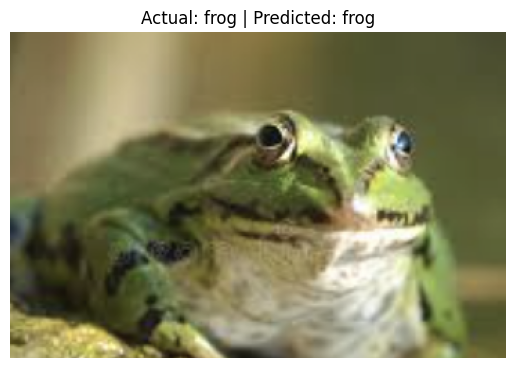

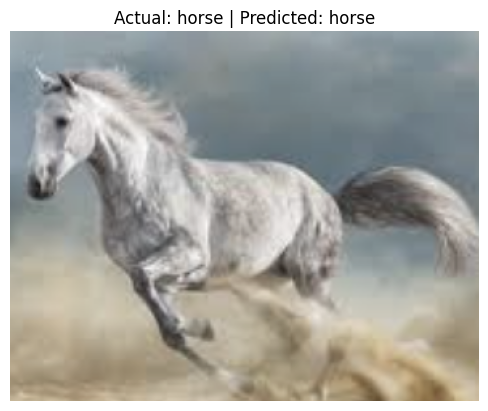

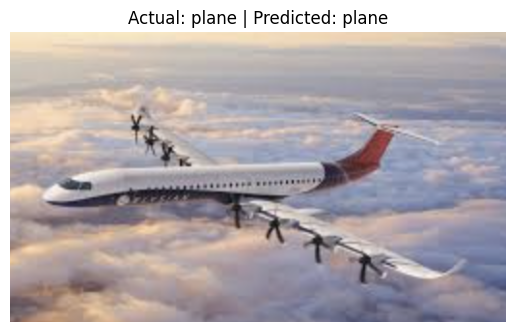

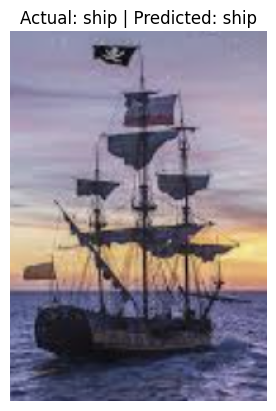

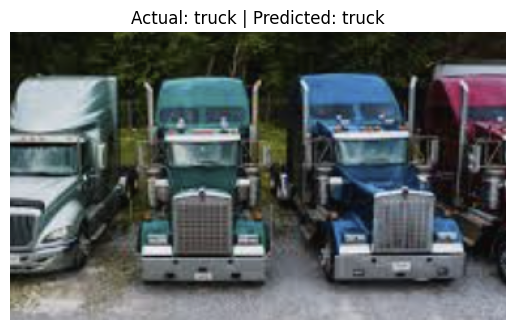


Overall Test Accuracy: 80.00%


In [ ]:
import os
from PIL import Image
import torch
from torchvision import transforms


# Path to your test folder (update this to your actual folder path)
test_folder = "test_images"
total = 0
correct = 0


# Loop through all files in the test folder
for file_name in os.listdir(test_folder):
    # Process only image files
    if file_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        file_path = os.path.join(test_folder, file_name)
        
        # Open the image and convert to RGB (in case it's RGBA or grayscale)
        img = Image.open(file_path).convert("RGB")
        
        # Apply transforms
        img_tensor = transform(img).unsqueeze(0)  # Add batch dimension
        
        # Move tensor to the same device as your model
        img_tensor = img_tensor.to(device)
        
        # Set model to evaluation mode and make a prediction
        model.eval()
        with torch.no_grad():
            output = model(img_tensor)
            _, pred_idx = torch.max(output, 1)
        
        # Get predicted and actual labels
        predicted_label = classes[pred_idx.item()]
        actual_label = file_name.split('.')[0]  # Assumes filename like 'bird.png'

        total += 1
        if predicted_label == actual_label:
            correct += 1
         # Show the image using matplotlib
        plt.imshow(img)
        plt.title(f"Actual: {actual_label} | Predicted: {predicted_label}")
        plt.axis('off')  # Hide axes for better image display
        plt.show()
        # Print the result
        
if total > 0:
    accuracy = (correct / total) * 100
    print(f"\nOverall Test Accuracy: {accuracy:.2f}%")
else:
    print("No valid images found in the test folder.")